# Tutorial 5: A Bayesian Inverse Problem - Inferring Ice Melt from Tide Gauges

In our previous tutorials, we have focused on the **forward problem**: predicting the Earth's response to a *known* change in ice mass. In this tutorial, we will tackle the more challenging **inverse problem**: inferring an *unknown* ice mass change from a set of sparse and noisy observations.

We will use the full power of the `pyslfp` and `pygeoinf` libraries to solve this problem within a **Bayesian framework**. Instead of finding a single "best-fit" solution, the Bayesian method provides a full **posterior probability distribution**. From this, we can extract the **posterior expectation**, which represents our most likely estimate of the ice melt pattern. The full posterior distribution also characterises the uncertainty in our knowledge about the ice mass change. Methods exist within `pygeoinf`  for working practically with the full posterior distribution though their computational cost remains rather high. Here, we will instead use the posterior distribution to fully characterise our knowledge of the global mean sea level (GMSL) change.

## Setup

We begin by importing the necessary components from `pyslfp`, `pygeoinf`, and other standard libraries. We will also initialize our `FingerPrint` model, which provides the underlying physics.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pyslfp as sl
import pygeoinf as inf
import cartopy.crs as ccrs

# Initialize the core fingerprint model - lower lmax to reduce calculation times for this tutorial.
fp = sl.FingerPrint(
    lmax=256,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fp.set_state_from_ice_ng()

## Step 1: Loading the Tide Gauge Data

We will use the real locations from the GLOSS tide gauge network. The `read_gloss_tide_gauge_data` function in our `utils` module handles loading this data for us.

All of the listed stations can be used, or a random sub-sample can be chosen. 

In [2]:
# Load the full list of GLOSS tide gauge stations
names, lats, lons = sl.read_gloss_tide_gauge_data()

# --- Configuration for data selection ---
use_all_stations = True
if not use_all_stations:
    number_of_stations_to_sample = 30
    

# -----------------------------------------
if use_all_stations:
    tide_gauge_points = list(zip(lats, lons))
else:
    # Create a reproducible random sample of stations
    random.seed(123)
    indices = random.sample(range(len(names)), number_of_stations_to_sample)
    sampled_lats = [lats[i] for i in indices]
    sampled_lons = [lons[i] for i in indices]
    tide_gauge_points = list(zip(sampled_lats, sampled_lons))

print(f"Using {len(tide_gauge_points)} tide gauge stations for the inversion.")

Using 75 tide gauge stations for the inversion.


## Step 2: Defining the Model Space

The next step is to define the space of possible solutions. Our unknown is the global pattern of **ice thickness change**. Within this application, we suppose that changes in ice thickness can only occur where there is already ice within our background model. To achieve this, we will start with a defined over the whole sphere, and then mutliply by a masking function that is one over the ice sheets and zero elsewhere. 

For the underlying space of functions, we use a `pygeoinf.symmetric_space.sphere.Sobolev` space with a prescribed order and smoothness. 

In [3]:
# Define the model space for the unknown ice thickness change
order = 2.0
scale_km = 500.0
scale = scale_km * 1000 / fp.length_scale

model_space = inf.symmetric_space.sphere.Sobolev(
    fp.lmax, order, scale, radius=fp.mean_sea_floor_radius
)

## Step 3: Defining the Forward Operator

Next, we must define the **forward operator**. This is the mathematical object that represents the complete chain of physical processes and measurements linking our model (ice thickness change) to our data (tide gauge readings).

Using the operator algebra of `pygeoinf`, we can build this complex chain by composing several simpler operators:

1.  **`ice_projection_operator`**: Takes a scalar-field defined everywhere on the surface and multiplied by a function equal to one over the current ice sheets. 
2.  **`ice_thickness_change_to_load_operator`**: Takes an ice thickness change field and converts it to a surface mass load.
3.  **`fp.as_sobolev_linear_operator`**: The main fingerprint operator. It takes the mass load and calculates the full physical response: `[sea-level, displacement, gravity, rotation]`.
4.  **`tide_gauge_operator`**: This takes the full response and evaluates the sea level change at the discrete locations of our tide gauges.

The final forward operator, `A`, is the composition of all three steps.

In [4]:
# Maps scalar-fields on sphere to be non-zero only over background ice sheets. 
op1 = sl.ice_projection_operator(fp, model_space)

# Maps an ice thickness change to the corresponding load. 
op2 = sl.ice_thickness_change_to_load_operator(fp, model_space)

# Maps a direct load to the full response. 
op3 = fp.as_sobolev_linear_operator(order, scale, rtol=1e-9)

# Maps the full response to the tide gauge values. 
op4 = sl.operators.tide_gauge_operator(op3.codomain, tide_gauge_points)

# Form the forward operator by composition. 
A = op4@ op3 @ op2 @ op1
data_space = A.codomain

# Form also a mapping from the model space to the sea level field for convenience. 
P = op3.codomain.subspace_projection(0)
A_sl = P @ op3 @ op2 @ op1

## Step 4: Setting up the LinearForwardProblem

Now we bundle the forward operator `A` with a model for our measurement errors. We'll assume the tide gauge measurements are corrupted by random, uncorrelated Gaussian noise with a given standard deviation. The amplitude of the errors is chosen to be commensurate with the synethetic sea level changes defined below. 

The `pygeoinf.LinearForwardProblem` class encapsulates this entire structure: **data = A(model) + error**.

In [5]:
# Define the data error statistics
tide_gauge_std_dev_m = 0.0005
tide_gauge_std_dev = tide_gauge_std_dev_m / fp.length_scale
data_error_measure = inf.GaussianMeasure.from_standard_deviation(
    data_space, tide_gauge_std_dev
)

# Bundle everything into a forward problem object
forward_problem = inf.LinearForwardProblem(
    A, data_error_measure=data_error_measure
)

## Step 5: Creating a synthetic data set

To test our inversion, we need synthetic data set generated from a chosen model.

We do this by defining a **prior probability distribution** on the model space. This "prior" represents our beliefs about the ice thickness change *before* seeing any data. 

For our prior, we start with a standard rotationally invariant Gaussian measure whose typical pointwise amplitude has been set to a desired value. We can then push this measure forward under the operator that takes functions over the whose surface to those that are non-zero only over the background ice sheets. 


In [6]:
# Set the initial model prior measure
pointwise_std_m = 0.1
pointwise_std = pointwise_std_m / fp.length_scale
initial_model_prior_measure = model_space.point_value_scaled_heat_kernel_gaussian_measure(scale, pointwise_std)

# Transform so that ice thickness change non-zero only over current ice sheets. 
model_prior_measure = initial_model_prior_measure.affine_mapping(operator=op1)

# --- Generate the synthetic ground truth and noisy data ---
model_true, data = forward_problem.synthetic_model_and_data(model_prior_measure)

## Step 6: Solving the Bayesian Inverse Problem

Now we have all the ingredients to solve the inverse problem. We use the `pygeoinf.LinearBayesianInversion` class, providing it with our forward problem and our prior.

The `model_posterior_measure` method applies Bayes' theorem to combine the prior information with the information from the data. The result is the **posterior probability distribution**, which represents our updated, combined state of knowledge.

In solving the Bayesian inverse problem it is necessary to repeatedly solve a linear system of equations on the data-space known as the Bayesian normal equations. The relevant linear operator can be written
$$
N = AQA^{*} + R, 
$$
where $A$ is the forward operator, $Q$ the model covariance, and $R$ the data covariance. As can be seen, each action of this operator requires one forward and one adjoint action of $A$, with in this case each operation involving a solution of the sea level equation. 

There are several methods available for solving this linear system, with `pygeoinf` requiring the user to select a solution method either from a standard set or by implementing their own custom approach. For problems with either large data sets or expensive forward problems it is generally best to apply iterative methods, and that is what is done here. Iterative methods, however, benifit massively from a good preconditioner being supplied, this being an operator that approximately solves the linear system, but whose action is relatively cheap to compute. 

To form a preconditioner in this case we will re-define our forward operator and model prior but using a substantially lower truncation degree in the calculations. Doing so lowers the accuracy of their results, but is also lowers the calcuation time dramatically. Having done this, we can form the associated Bayesian inverse problem at the lower truncation degree and form its normal operator which is, of course, define on the same data space as our initial problem. The matrix form of this new normal operator can be computed explicitly at reasonable cost, and the action of its inverse determine cheaply by Cholesky factorising it and then performing back substitution for each new right hand side. In this manner we arrive at a reasonable preconditioner for the problem at hand. 

In the code block below we reform the necessary forward problem and prior at the lower degree. In practice, it would have been useful to wrap this construction process within a function to avoid code repetition. 

In [7]:
# Repeat the set up of the forward problem, but now using a lower lmax
lmax_precon = 64

fp_precon = sl.FingerPrint(
    lmax=lmax_precon,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fp_precon.set_state_from_ice_ng()

model_space_precon = inf.symmetric_space.sphere.Sobolev(
    fp_precon.lmax, order, scale, radius=fp_precon.mean_sea_floor_radius
)

op1_precon = sl.ice_projection_operator(fp_precon, model_space_precon)
op2_precon = sl.ice_thickness_change_to_load_operator(fp_precon, model_space_precon)
op3_precon = fp_precon.as_sobolev_linear_operator(order, scale, rtol=1e-9)
op4_precon = sl.operators.tide_gauge_operator(op3_precon.codomain, tide_gauge_points)
A_precon = op4_precon@ op3_precon @ op2_precon @ op1_precon

initial_model_prior_measure_precon = model_space_precon.point_value_scaled_heat_kernel_gaussian_measure(scale, pointwise_std)
model_prior_measure_precon = initial_model_prior_measure_precon.affine_mapping(operator=op1_precon)

forward_problem_precon = inf.LinearForwardProblem(
    A_precon, data_error_measure=data_error_measure
)

Having formed the reduced-degree problem, we can set up the necessary Bayesian inverse problems, extract the approximate normal operator for preconditioning, and then solve the full problem iteratively. Note that running this calculation at degree 256 will still take several minutes, but without preconditioning this would be substantially greater. 

In [8]:
# Set up the inversion for the preconditioning system
bayesian_inversion_precon = inf.LinearBayesianInversion(forward_problem_precon, model_prior_measure_precon)

# Get the normal operator for the preconditioning system.
normal_operator_precon = bayesian_inversion_precon.normal_operator

# Form its inverse using Cholesky factorisation. 
print("Forming the preconditioner...")
solver = inf.CholeskySolver()
inverse_normal_operator_precon = solver(normal_operator_precon)

# Set up the Bayesian inversion method
bayesian_inversion = inf.LinearBayesianInversion(forward_problem, model_prior_measure)

# Solve for the posterior distribution
print("Solving the linear system...")
model_posterior_measure = bayesian_inversion.model_posterior_measure(
    data, inf.CGMatrixSolver(), preconditioner= inverse_normal_operator_precon
)

# Get the posterior expectation
model_posterior_expectation = model_posterior_measure.expectation

# print out the total number of calls to the fingerpint solver - one will be for generating the synthetic data. 
print(f'Number of solutions of the fingerprint problem = {fp.solver_counter}')

Forming the preconditioner...
Solving the linear system...
Number of solutions of the fingerprint problem = 18


## Step 7: Analyzing and Visualizing the Result

The primary result we are interested in is the **posterior expectation**. This is our best estimate of the true ice thickness change, given our prior beliefs and the information contained in the tide gauge data.

The full posterior distribution also contains the **posterior covariance**, which quantifies our uncertainty. For this tutorial, we will focus solely on the posterior expectation.

### Plotting the Inferred Ice Melt

First, we will create two separate plots to compare the "ground truth" ice melt with our inferred result:
1.  **The True Model:** The actual ice thickness change we were trying to recover.
2.  **The Posterior Expectation:** Our best estimate, which we hope resembles the true model.

To ensure a fair visual comparison, we will calculate a common color scale based on the maximum absolute value across both fields.

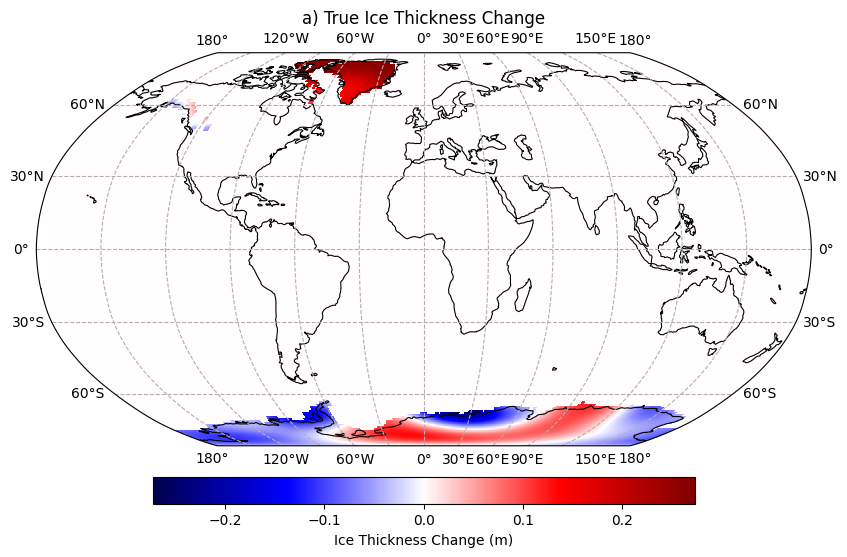

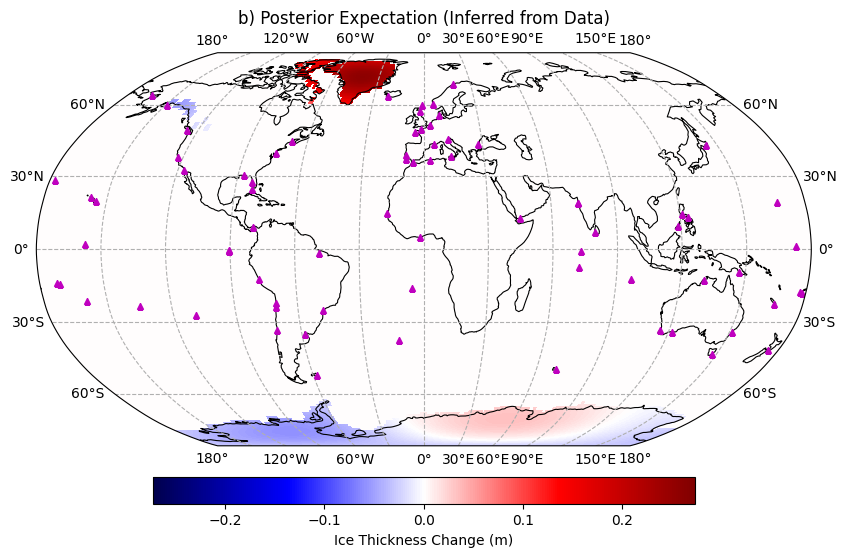

In [9]:
# --- Calculate a shared, symmetric color scale for the ice thickness plots ---
# We mask with the ice projection to avoid including NaNs in the calculation
ice_mask = fp.ice_projection(0)
max_abs_ice_change = np.nanmax(
    np.abs(
        np.concatenate([
            (model_true * ice_mask).data.flatten(),
            (model_posterior_expectation * ice_mask).data.flatten()
        ])
    )
) * fp.length_scale

# --- Plot 1: The "Ground Truth" Model ---
fig1, ax1, im1 = sl.plot(
    model_true * fp.length_scale,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_ice_change,
    vmax=max_abs_ice_change
)
ax1.set_title("a) True Ice Thickness Change")
fig1.colorbar(im1, ax=ax1, orientation="horizontal", pad=0.05, shrink=0.7, label="Ice Thickness Change (m)")


# --- Plot 2: The Posterior Expectation (Our Best Estimate) ---
fig2, ax2, im2 = sl.plot(
    model_posterior_expectation  * fp.length_scale,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_ice_change,
    vmax=max_abs_ice_change
)
ax2.set_title("b) Posterior Expectation (Inferred from Data)")

# Mark the tide gauge locations
lats = [p[0] for p in tide_gauge_points]
lons = [p[1] for p in tide_gauge_points]
ax2.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())

fig2.colorbar(im2, ax=ax2, orientation="horizontal", pad=0.05, shrink=0.7, label="Ice Thickness Change (m)")
plt.show()

### Plotting the Predicted Sea Level

As a final check, we can use our inferred ice melt pattern (`model_posterior_expectation`) to predict the global sea-level fingerprint. By comparing this predicted fingerprint to the "true" fingerprint, we can visually assess how well our inversion has captured the large-scale signal.

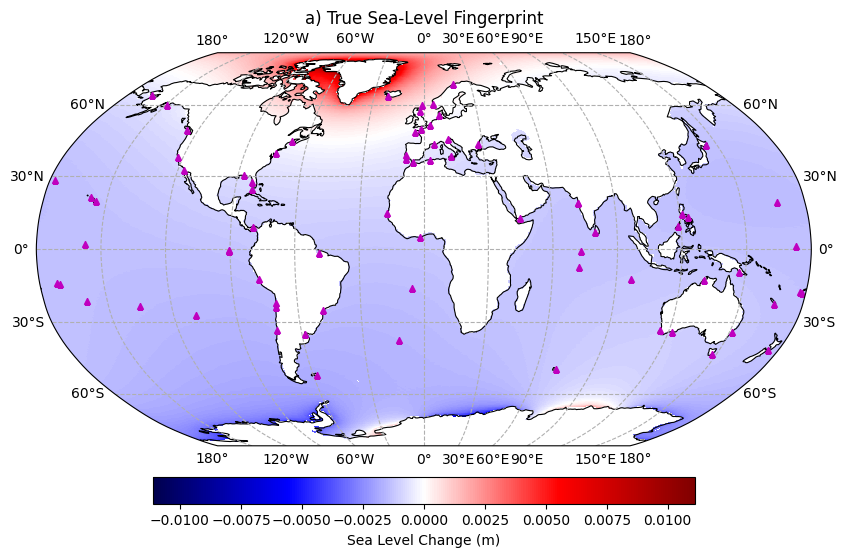

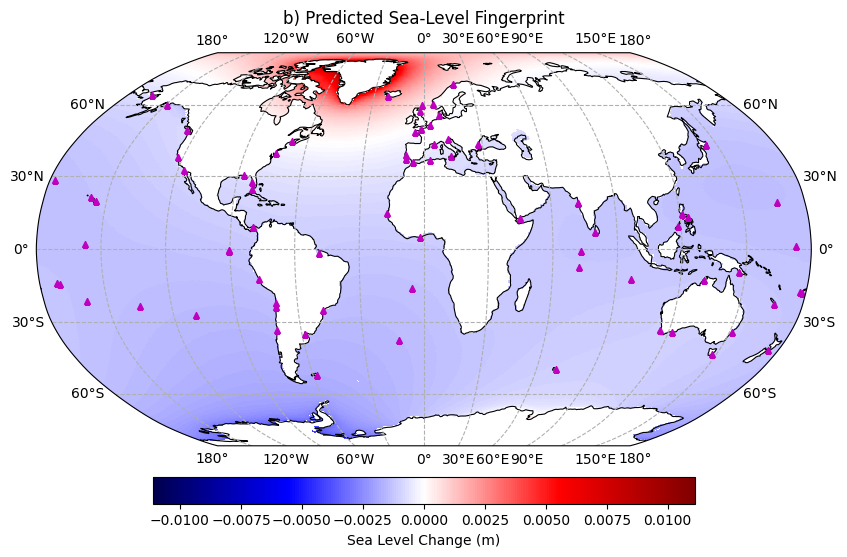

In [10]:

# Calculate the predicted sea-level field from the posterior expectation model
sea_level_posterior = A_sl(model_posterior_expectation)

# Calculate the true sea level change. 
sea_level_true = A_sl(model_true)

# --- Calculate a shared, symmetric color scale for the sea-level plots ---
ocean_mask = fp.ocean_projection()
max_abs_sl_change = np.nanmax(
    np.abs(
        np.concatenate([
            (sea_level_true * ocean_mask).data.flatten(),
            (sea_level_posterior * ocean_mask).data.flatten()
        ])
    )
) * fp.length_scale


# --- Plot 3: The "True" Sea-Level Field ---
fig1, ax1, im1 = sl.plot(
    sea_level_true * ocean_mask * fp.length_scale,    
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_sl_change,
    vmax=max_abs_sl_change
)
ax1.set_title("a) True Sea-Level Fingerprint")
ax1.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())
fig1.colorbar(im1, ax=ax1, orientation="horizontal", pad=0.05, shrink=0.7, label="Sea Level Change (m)")



# --- Plot 4: The Sea-Level Field Predicted by the Inversion ---
fig2, ax2, im2 = sl.plot(
    sea_level_posterior * fp.ocean_projection()* fp.length_scale,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_sl_change,
    vmax=max_abs_sl_change
)
ax2.set_title("b) Predicted Sea-Level Fingerprint")
ax2.plot(lons, lats, 'm^', markersize=5, transform=ccrs.PlateCarree())
fig2.colorbar(im2, ax=ax2, orientation="horizontal", pad=0.05, shrink=0.7, label="Sea Level Change (m)")
plt.show()

## Mapping the posterior onto a lower-dimensional space

Comparison of the true and posterior mean ice thickness changes suggests that while the tide gauge data can recover broadly correct features of the ice thickness change, it is not possible to recover fine spatial details. This is not surprising given the relative sparsity of the data and the fact that most tide gauges are located far from the polar regions. 

Despite this limitation, we can still investigate the extent to which certain average properties of the ice thickness change can be determined. First, we look at the estimated global mean sea level (GMSL) change. To do so, we set up, via a simple mass balance, a LinearOperator from the model space to resulting 1D property space. The model posterior measure can be pushed forward under this mapping, and we can then visualise the resulting distribution. 

Note that pushing forward the posterior measure to an n-dimensional space on which we determine the concrete form of the resulting covariance requires n additional solutions of the Bayesian normal equations. As a result, the calculation here will take a comparable time to that above for finding the full posterior expectation. 

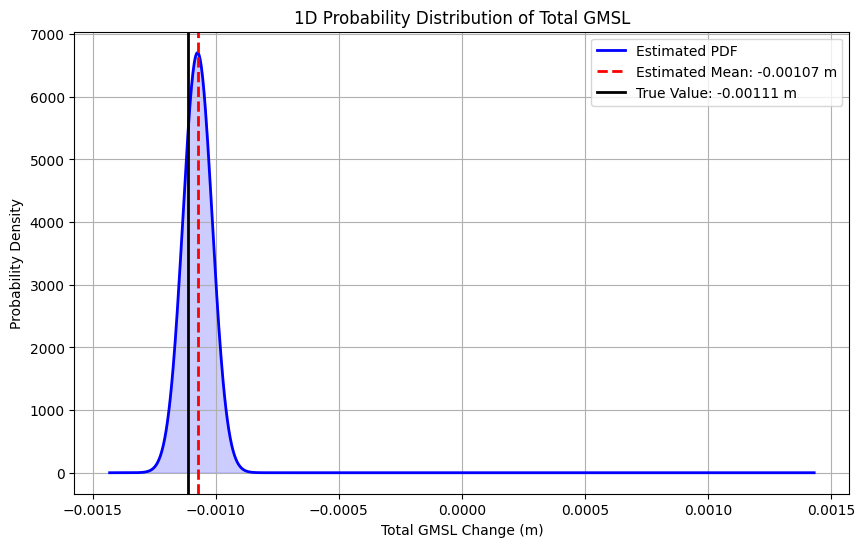

In [11]:
# Set the weighting function for GMSL estimates  - Note that length scale factor to dimensionalise the result.
GMSL_weighting_function =  -fp.ice_density * fp.one_minus_ocean_function * fp.ice_projection(0) * fp.length_scale / (fp.water_density * fp.ocean_area)

# Form the mapping to GSML. 
B = sl.averaging_operator(model_space, [GMSL_weighting_function])

# Get the true GMSL
GMSL_true = B(model_true)

# Push forward the posterior to the GMSL space.
GMSL_posterior_measure = model_posterior_measure.affine_mapping(operator=B)

# Get the measure as a scipy distribution. 
GMSL_distribution = GMSL_posterior_measure.as_multivariate_normal()


# Plot the PDF for GMSL. 
gmsl_mean = GMSL_distribution.mean[0]
gmsl_std = np.sqrt(GMSL_distribution.cov[0, 0])
x_max = np.max([np.abs(gmsl_mean - 6 * gmsl_std), np.abs(gmsl_mean + 6 * gmsl_std)])
x_axis = np.linspace(-x_max, x_max, 1000)
pdf_values = GMSL_distribution.pdf(x_axis)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, pdf_values, color='blue', lw=2, label='Estimated PDF')
plt.fill_between(x_axis, pdf_values, color='blue', alpha=0.2)
plt.axvline(gmsl_mean, color='red', linestyle='--', lw=2, label=f'Estimated Mean: {gmsl_mean:.5f} m')
plt.axvline(GMSL_true[0], color='black', linestyle='-', lw=2, label=f'True Value: {GMSL_true[0]:.5f} m')
plt.title('1D Probability Distribution of Total GMSL')
plt.xlabel('Total GMSL Change (m)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

In this tutorial, we have successfully performed a Bayesian inversion to infer a global ice melt pattern from sparse, noisy data from the GLOSS tide gauge network.

The results show that:
* The **posterior expectation** for ice melt successfully recovers the large-scale features of the **true model**, even though it was derived from only a small number of global tide gauges.
* The **predicted sea-level fingerprint** from our inversion result is a good match for the true fingerprint, demonstrating that our solution is consistent with the physics of the problem.
* The estimates for GMSL change are quite accurate, with our results also providing rigorous uncertainties subject to our choice of prior. 
  